# Лабораторна робота 3: Згорткові нейронні мережі для передачі стилістики "Neural Style Transfer"

Для виконання цієї лабораторної роботи зверніть увагу на посилання [Gatys et al. (2015).](https://arxiv.org/abs/1508.06576)

В цій лабораторній роботі ви будете оптимізувати значення пікселей зображення, налаштовуючи нейронну мережу так, щоб значення функції втрат було мінімальним. В попередніх двох завданнях Ви намагалися оптимізувати функцію втрат для знаходження найкращіх значеннь вагових коєфіцієнтів.  

Під час виконання вам дозволено користуватися будь-якими зручними для вас бібліотеками.  

Роботи ідентифіковані як ІДЕНТИЧНІ  або роботи БЕЗ висновків одразу отримують 0 балів.

## 1 - Необхідні бібліотеки

Імпорт необхідних бібліотек та пакетів для лабораторної роботи 3:

In [3]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor
import pprint


## 2 - Постановка завдання до лаборатоної роботи:

Задача навчання нейронної мережі створювати зображення в стилістиці робіт певного митця (Neural Style Transfer - NST) - є дуже цікавою та зрозумілою в контексті застосування глибинних нейронних мереж, в часності згорткових нейромереж. Задача передачі стилю об'єднує два зображення, а саме: зображення <strong>"зміст" (C)</strong> та <strong>"стиль" (S)</strong>, щоб створити нове зображення <strong> "згенероване нейромережею" (G) </strong>. Сформоване зображення G поєднує "зміст" зображення C зі "стилем" зображення S.

Для навчального прикладу в цій лаборатоній роботі Ви будете використовувати зображення музею Лувр у Парижі (контентне зображення C) та імпресіоністичним стилем Клода Моне (змістове зображення S) для створення "штучного зображення". 

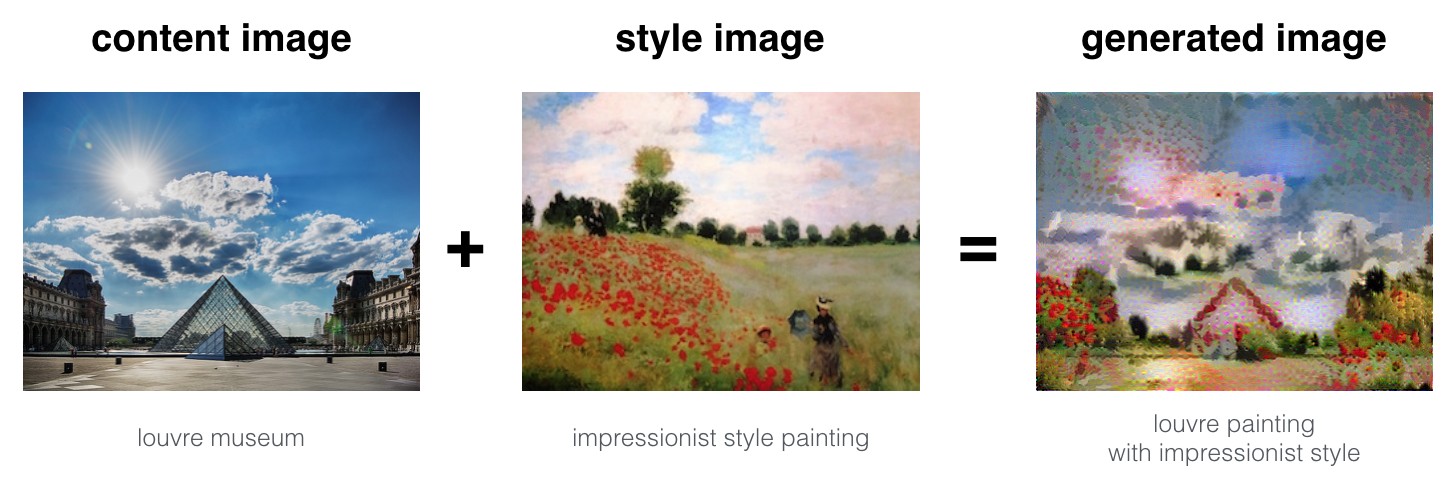

## 3 - Transfer Learning

Для переносу стилю з одного зображення на інше використовуєють попередньо навчену згорткову мережу і "донавчають" її. Ідея використання мережі, попередньо навченої для іншої задачі, та подальше застосування її до новогї називається трансфертним навчанням (transfer learning).   

В цій лабораторній роботі Ви будете використовувати попередньо навчену згорткову мережу VGG із [оригінальної статті] (https://arxiv.org/abs/1508.06576). Зокрема, Ви будете використовувати VGG -19, це 19-шарова версія мережі VGG. Ця модель вже пройшла навчання у дуже великій базі даних ImageNet і навчилася розпізнавати різноманітні ознаки низького рівня (на більш дрібних шарах) та ознаки (фічі) високого рівня (на більш глибоких шарах).  

Для того щоб завантажити попередньо навчену мережу Вам необхідно додати файл `vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5` до Вашого Colab. (Це може зайняти кілька секунд.)

In [4]:
tf.random.set_seed(272)
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

vgg.trainable = False
pp.pprint(vgg)

## 4 - Neural Style Transfer (NST)

Для того щоб алгоритм генерував красиві зображення, необхідно переконатися, що зміст згенерованого зображення буде відповідати змісту вхідного зображення. Іншими словами, зображення, що буде згенеровано, також містило піраміду, навколишні будівлі, хмари, сонце і т.п.

Алгоритм переносу стилю складається з трьох етапів:

- для початку необхідно визначити функцію втрат для зображеня, на яке буде накладатися певний стиль (зображення контенту) $J_{content}(C,G)$
- далі слід визначити функцію втрат для зображеня зі стилем, який буде передаватися контеконтекстному зображенню $J_{style}(S,G)$
- фінальна частина - це об'єднання двох цих блоків $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$.

### 4.1 - Обчислення функції втрат для зображення з контентом

#### 4.1.1 - Як зробити так, щоб створене нейромережею зображеня G співпало за наповненням з контентним зображенням C?! 

Ваша основна мета зробити так, щом зміст створеного нейромережею зображення G відповідав змісту зображення з контентом C. Для цього необхідно розуміти поняття <b> мілинних та глибоких шарів </b>:

* Більш мілинни шари згорткової мережі (ConvNet), як правило, виявляють фічі нижчого рівня такі, як <i> краї та прості текстури</i>.
* Більш глибокі шари мають тенденцію виявляти фічі більш високого рівня такі, як <i>складні текстури та класи об’єктів</i>.

#### Вибір "внутрішніх" шарів активації $a^{[l]}$ :
Для того, щоб "згенероване" зображення G мало схожий зміст із вхідним зображенням C. Припустимо, що були обрані активації деяких шарів для представлення вмісту зображення.
* На практиці ви отримаєте найкращі результати з точки зору візуалу створеного зображення, якщо оберете <b>внутрішній</b> шар мережі середнім за глибиною. Це гарантує, що мережа буде виявляти фічі як вищого, так і нижчого рівня.
* Але поекспериментувати з глибиною внутрішніх шарів завжди можна!

#### Пряме поширення для контентного зображення "C:"
* Задайте зображення C як вхід для попередньо підготовленої мережі VGG та запустіть пряме поширення.  
* Нехай $a^{(C)}$ буде активацією прихованого шару у вибраному шарі. Для того щоб обчислити функцію втрат необхідно розгорнути трьохвимірний тензор в двовимірній матриці $n_H \times n_W \times n_C$, де $n_H$ - висота зображення, $n_W$ - ширина зображення, $n_C$ - кількість каналів в прихованому шарі.

#### Пряме поширення для штучно згенерованого зображення "G":
* Повторіть цей процес із зображенням G: задайте G як вхідний сигнал і запустіть пряме поширення.
* Нехай $ a^{(G)} $ - відповідна активація прихованого шару.

У наведеному прикладі контентне зображення С буде зображенням Лувру в Парижі. Запустіть код нижче, щоб побачити зображення.

The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.


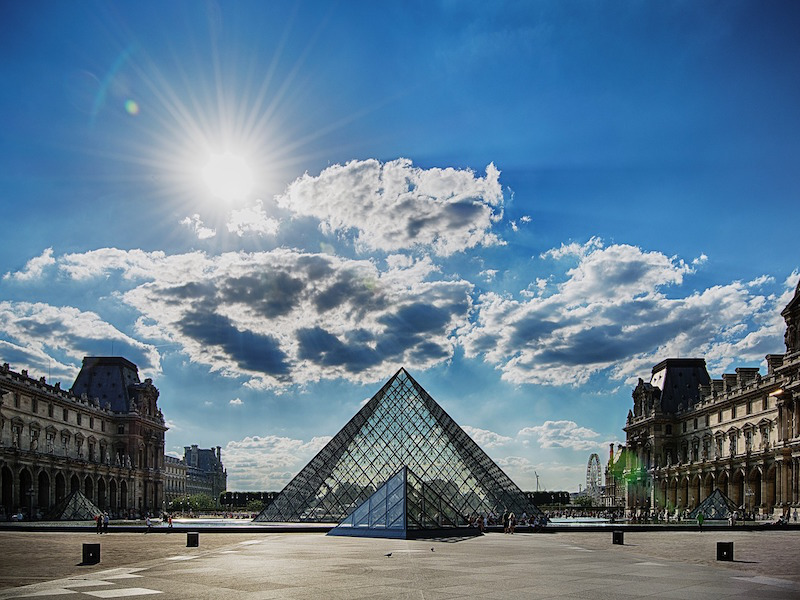

In [5]:
content_image = Image.open("louvre.jpg")
print("The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.")
content_image

#### 4.1.2 - Обчислення функції втрат для контентного зображення $J_{content}(C,G)$
Для того, щоб обислити втрати для контентного зображення необхідно скористатися формулою (1):

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

* Тут $n_H, n_W$ та $n_C$ - це висота, ширина та кількість каналів прихованого шару, які необхідно обрати.
* $a^{(C)}$ та $a^{(G)}$ це трьохвимірні масиви, відповідних активацій прихованих шарів. 
* Для обчислення функції втрат $ J_ {content} (C, G) $, можна розгорнути ці тривимірні масиви (по факту це тензори) у 2D -матрицю, як показано на рисунку.
* Технічно цей крок розгортання не потрібен для обчислення $J_ {content}$, але це буде гарною практикою, коли вам потрібно буде виконати подібну операцію пізніше, щоб обчислити функцію втрат для $J_ {style}$.

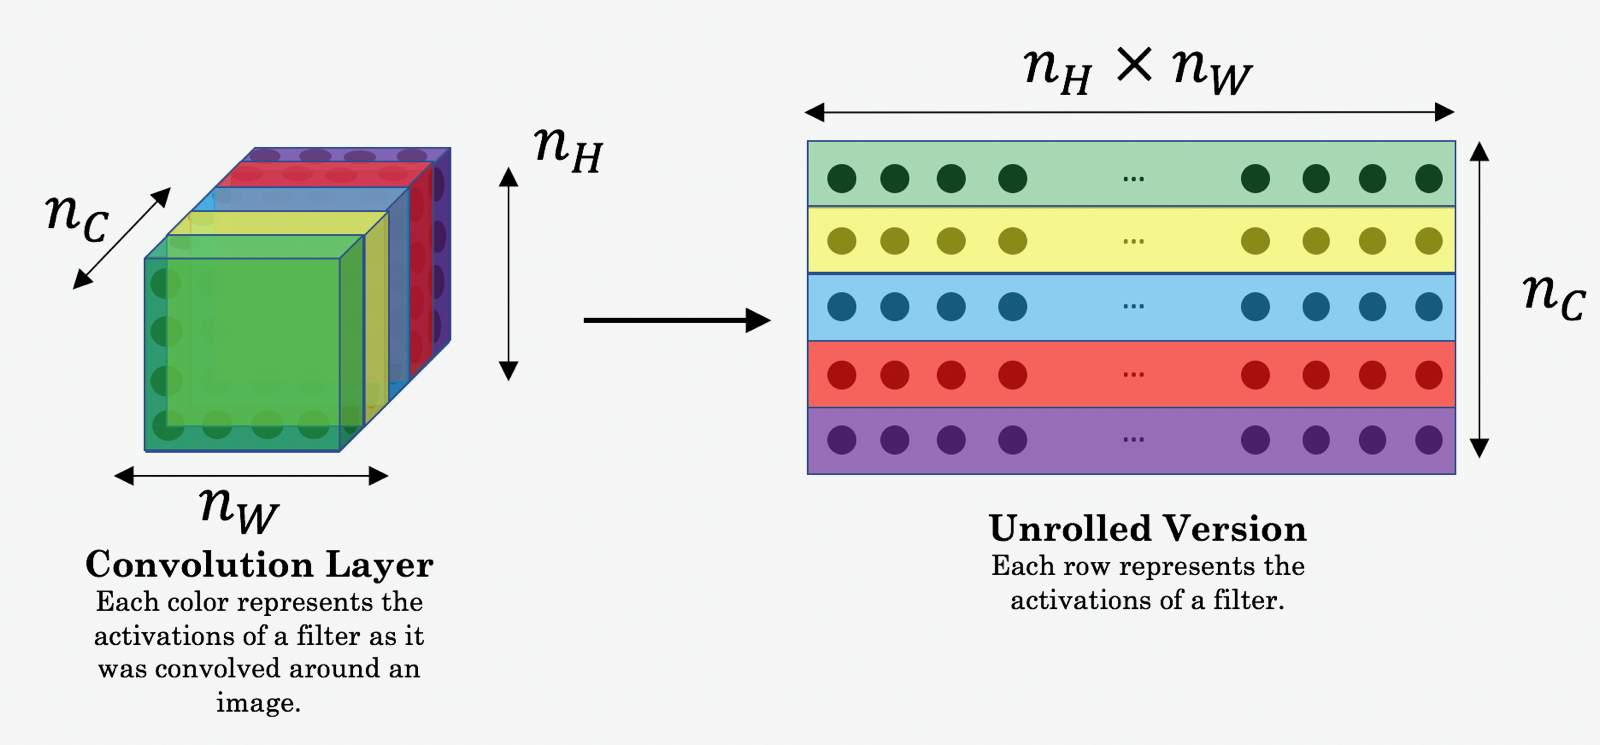

### Завдання 1: compute_content_cost

Для розрахунку "content cost" використовуйте TensorFlow. 

**Примітки до завдання 1**: 

`a_G`: приховані шари активацій, які відповідають за контент зображення  G
<br>
`a_C`: приховані шари активацій, які відповідають за контент зображення C 

Три основні етапи для реалізації цієї функції:
1. Перевірка розмірності `a_G`: 
    - для того щоб перевірити розмірність тензору `X`, скористайтесь: `X.get_shape().as_list()`
2. разгорніть `a_C` та `a_G` як проілюстровано на зображенні
    - скористуйтеся наступними функціями: [tf.transpose](https://www.tensorflow.org/api_docs/python/tf/transpose) та [tf.reshape](https://www.tensorflow.org/api_docs/python/tf/reshape).
3. обчислення функції втрат для контентного зображення:
    - скористуйтеся наступними функціями: [tf.reduce_sum](https://www.tensorflow.org/api_docs/python/tf/reduce_sum), [tf.square](https://www.tensorflow.org/api_docs/python/tf/square) та [tf.subtract](https://www.tensorflow.org/api_docs/python/tf/subtract).
    
    
#### Як "розгорнути" тензор:
* для того щоб розгорнути тензор необхідно змінити форму $(m,n_H,n_W,n_C)$ на $(m, n_H \times n_W, n_C)$.
* `tf.reshape(tensor, shape)` приймає список цілих чисел, які представляють собою необхідну форму вихідного сигналу.
* Значення `-1` , параметру `shape` є показником того, що у функції втрат правильне значення розмірності вихідного тензору та він містить всі змінні вхідного тензору.
* Функція `tf.reshape(a_C, shape=[m, n_H * n_W, n_C])` це теж саме, що і `tf.reshape(a_C, shape=[m, -1, n_C])`.
* для впорядкування розмірностей можна використати `tf.transpose(tensor, perm)`, де `perm` це список цілих чисел, що містить вихідний індекс розмірностей.
* Наприклад, `tf.transpose(a_C, perm=[0,3,1,2])` змінює розмірність $(m, n_H, n_W, n_C)$ на $(m, n_C, n_H, n_W)$.
<!-- * Є багато варіантів розгортання тензору  -->
* Вам не обов'язково потрібен `tf.transpose`, щоб "розгорнути" тензори, але це корисна функція для практики та розуміння інших ситуацій, які можливі в роботі з глибинними мережами.


In [8]:
def compute_content_cost(content_output, generated_output):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    a_C = content_output[-1]
    a_G = generated_output[-1]
    
    
    # Retrieve dimensions from a_G
    m, n_H, n_W, n_C = a_G.get_shape().as_list()# your code
    
    # Reshape a_C and a_G
    a_C_unrolled = tf.reshape(a_C,(m,n_H*n_W,n_C))
    a_G_unrolled =tf.reshape(a_G,(m,n_H*n_W,n_C))
    
    # compute the cost with tensorflow
    J_content = tf.reduce_sum((a_C-a_G)**2/(4*n_H*n_W*n_C)) # your code
    
    
    return J_content

In [9]:
tf.random.set_seed(1)
a_C = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
a_G = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
J_content = compute_content_cost([a_C], [a_G])
J_content_0 = compute_content_cost([a_C], [a_C])

print("J_content = " + str(J_content))


J_content = tf.Tensor(7.056877, shape=(), dtype=float32)


**Результат, який необхідно отримати**:

<table>
    <tr>
        <td>
            <b>J_content</b>  
        </td>
        <td>
            7.0568767
        </td>
    </tr>

</table>


    
**Що необхідно пам'ятати!:**
    
- Функція втрат для контентного зображення використовує активацію прихованих шарів мережі та порівнює на скільки відрізняються $a^{(C)}$ та $a^{(G)}$. 
- Після того, як Ви мінімізуєте значення функції втрат для контентного зображення, далі в лабораторній роботі це Вам допоможе в розумінні, що $G$ та $C$ однакові по вмісту.


### 4.2 - Визначення функції втрат для стилю

В якості стилю нового зображення можна використовувати наступне зображення (картина Клода Моне): 

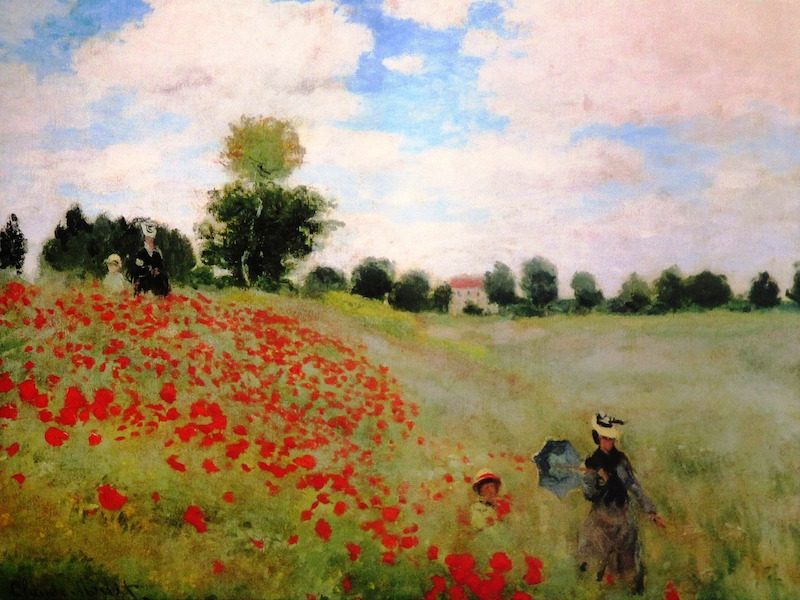

In [10]:
example = Image.open("monet_800600.jpg")
example

Новому зображенню нейромережа надасть основні риси стилю <b>[імпресіонізм](https://en.wikipedia.org/wiki/Impressionism)</b>.

В наступній частині лабораторної роботи Вам необхідно визначити функцію втрат для стилю зображення $J_{style}(S,G)$!

#### 4.2.1 - Матриця Стилю (Style Matrix)

#### Матриця Грама
* Матрицю стилю ще часто називають матрицею Грама.
* В лінійній алгебрі, матриця Грама G, яка складається з набору векторів $(v_{1},\dots ,v_{n})$ це матриця скалярного добутку записана наступним чином ${\displaystyle G_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})  }$. 
* Іншими словами, $G_{ij}$ порівнює на скількі схожі $v_i$ та $v_j$: Якщо вони дуже схожі, можна очікувати, що вони матимуть великий скалярний добуток, а отже, значення $ G_ {ij} $ буде великим. 

#### Два значення зміної $G$
* Дотримуючись загальноприйнятої в літературі термінології: 
    * $G$ використовується для позначення матриці стилю (або матриця Грама) 
    * $G$ позначає згенероване нейромережею зображення. 
* Для уникнення плутанини $G_{gram}$ буде використовуватись для позначення матриці Грама, а $G$ для згенерованого зображення.

#### Матріца Грама $G_{gram}$
Для того, щоб розрахувати матрицю стилю, необхідно помножити "розгорнуту" матрицю фільтру на її транспоновану:

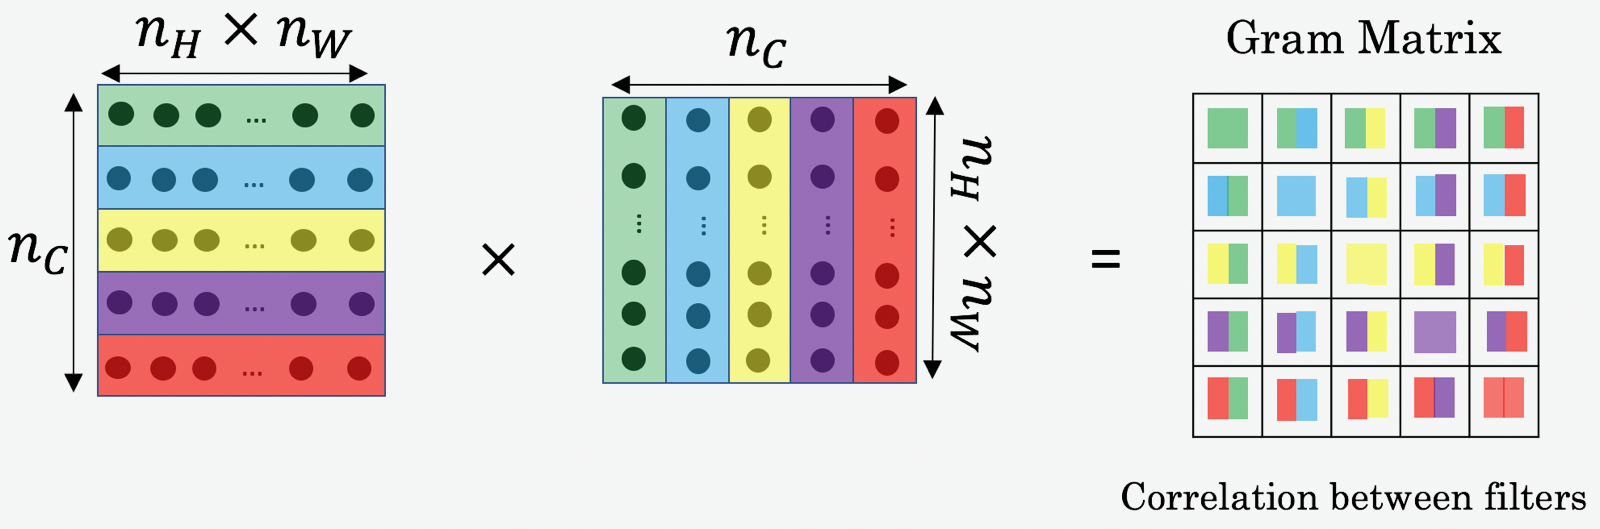

$$\mathbf{G}_{gram} = \mathbf{A}_{unrolled} \mathbf{A}_{unrolled}^T$$

#### $G_{(gram)ij}$: кореляція
Результатом є матриця розмірності $(n_C, n_C)$, де $n_C$ - кількість фільтрів (каналів). Значення $G _ {(грам) i, j}$ вимірює, наскільки активації фільтра $i$ подібні до активацій фільтра $j$.

#### $G_{(gram),ii}$: преобладання візерунків чи текстур (prevalence of patterns or textures)
* Діагональні елементи $G _ {(gram) ii}$ вимірюють, наскільки "активним" є фільтр $ i $.
* Наприклад, припустимо, що фільтр $i$ виявляє вертикальні текстури на зображенні. Тоді $G _ {(gram) ii}$ вимірює, наскільки загальними є вертикальні текстури на зображенні в цілому.
*  Якщо значення $G _ {(gram) ii}$ велике, це означає, що зображення має багато вертикальної текстури.


Після того, як будуть виявлені основні фічі ($G _ {(грам) ii}$), а також те, як часто різні фічі зустрічаються разом ($G _ {(грам) ij}$), матриця стилів $G_ {грам}$ вимірює стиль зображення.

### Завдання 2 - gram_matrix
* За допомогою TensorFlow реалізуйте функцію, яка обчислює матрицю Грама матриці A.
    * Для цього скористайтесь наступоною формулою для знаходження матриці Грама для матриці А: $G_A = AA^T$. 
* Тут Ви можете скористатися цими функціями: [matmul](https://www.tensorflow.org/api_docs/python/tf/matmul) та [transpose](https://www.tensorflow.org/api_docs/python/tf/transpose).

In [17]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """  
    
    GA = A @ tf.transpose(A)
    

    return GA

In [18]:
tf.random.set_seed(1)
A = tf.random.normal([3, 2 * 1], mean=1, stddev=4)
GA = gram_matrix(A)

print("GA = \n" + str(GA))


GA = 
tf.Tensor(
[[ 63.1888    -26.721275   -7.7320204]
 [-26.721275   12.76758    -2.5158243]
 [ -7.7320204  -2.5158243  23.752384 ]], shape=(3, 3), dtype=float32)


**Результат, який необхідно отримити**:

<table>
    <tr>
        <td>
            <b>GA</b>
        </td>
        <td>
           [[ 63.1888    -26.721275   -7.7320204] <br>
 [-26.721275   12.76758    -2.5158243] <br>
 [ -7.7320204  -2.5158243  23.752384 ]] <br>
        </td>
    </tr>

</table>

#### 4.2.2 - Визначення функції втрат для стилю

Після того, як Ви вірно обчислили матрицю Грама необхідно вирішити задачу мінімізації відстані між матрицею Грама "стильового" зображення S та матрицею Грама "згенерованого" мережею зображення G.
* Тут Ви будете використовувати лише один прихований шар $a^{[l]}$.  
* Функція втрат стилю для цього шару визначається як: 

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2\tag{2} $$

* $G_{gram}^{(S)}$ матриця Грама для "стильового" зображення.
* $G_{gram}^{(G)}$ матриця Грама для "згенерованого" мережею зображення.
* Пам’ятайте, що функція витрат для стилю обчислюється за допомогою активацій прихованого шару для обраного прихованого шару в мережі $a^{[l]}$


### Завдання 3 - compute_layer_style_cost
Обчислення функції втрат стилю для певного шару. 

Для реалізації цієї функції треба виконати три наступних кроки:
1. Для вилучення розмірів з тензору X, необхідно використати: `X.get_shape () as_list ()`.
2. Розгорніть активації прихованого шару a_S та a_G у 2D -матрицях.
    - Використовуйте [tf.transpose](https://www.tensorflow.org/api_docs/python/tf/transpose) та [tf.reshape](https://www.tensorflow.org/api_docs/python/tf/reshape).
3. Обчисліть матрицю стилів зображень S і G.
4. Обчисліть функцію витрат для стилю:
    - Ці посилання Вам будуть необхідні [tf.reduce_sum](https://www.tensorflow.org/api_docs/python/tf/reduce_sum), [tf.square](https://www.tensorflow.org/api_docs/python/tf/square) та [tf.subtract](https://www.tensorflow.org/api_docs/python/tf/subtract).
    
    
#### Підказка до завдання 3
* Оскільки розмірність активацій - $ (m, n_H, n_W, n_C) $, тоді як бажана розмірність розгорнутої матриці - $ (n_C, n_H* n_W) $, порядок розмірності фільтра $ n_C $ змінюється. Отже, `tf.transpose` можна використовувати для зміни порядку розмірності фільтра.


In [38]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # Retrieve dimensions from a_G 
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images from (n_H * n_W, n_C) to have them of shape (n_C, n_H * n_W)
    a_S = tf.transpose(tf.reshape(a_S,(n_H*n_W,n_C)))
    a_G = tf.transpose(tf.reshape(a_G,(n_H*n_W,n_C)))

    # Computing gram_matrices for both images S and G
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    
    # Computing the loss
    J_style_layer = tf.reduce_sum(((GS-GG)**2))/(4*(n_C**2))*((n_H*n_W)**2)
    
    return J_style_layer

In [39]:
tf.random.set_seed(1)
a_S = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
a_G = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
J_style_layer_GG = compute_layer_style_cost(a_G, a_G)
J_style_layer_SG = compute_layer_style_cost(a_S, a_G)


print("J_style_layer = " + str(J_style_layer_SG))



J_style_layer = tf.Tensor(918671.06, shape=(), dtype=float32)


**Результат, який необхідно отримати**:

<table>
    <tr>
        <td>
            <b>J_style_layer</b>
        </td>
        <td>
           14.017805
        </td>
    </tr>

</table>

#### 4.2.3 Встановлення ваг різних шарів стилю

* На попередньому етапі ми фіксували тільки значення функції втрат стилю для одного шару 
* Результати стануть кращіми, якщо об'єднати значення функції втрат зі всіх шарів стилю.
* Вага кожного шару позначається, як ($\lambda^{[l]}$) і показує як кожний шар впливає на фінальний результат розрахунку функції втрат для стилю.
* Для створення кращого зображення можна поексперементувати зі значеннями ваг на кожному із шарів стилю та подивитись як буде змінюватись згенероване зображення $G$.
* Для початку вcтановіть всі ваги однаковими в діапазоні від 0 до 1.    $\sum_{l}^L\lambda^{[l]} = 1$

Виведіть шари згорткової мережі:

In [ ]:
for layer in vgg.layers:
    print(layer.name)

Подивіться на вихід шару `block5_conv4`. Пізніше цей шар буде шаром вмісту, який буде представляти вхідне зображення зображення.

In [ ]:
vgg.get_layer('block5_conv4').output

Шари стилю та функція витрат:

In [ ]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

Об'єднати окремі функції витрат стилю можна скориставшись формулою:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

де значення $ \lambda^{[l]} $ подано у "STYLE_LAYERS".


### Завдання 4 -  compute_style_cost
Поєднання всіх частин разом

* Функція compute_style_cost (...) вже реалізована. 
* Ця функція викликає параметр `compute_layer_style_cost(...)` декілька разів, зважує їх результати використовуючи значення з `STYLE_LAYERS`. 
* Будь ласка, прочитайте специфікацію до цієї функціїї, щоб зрозуміти що вона виконує.

#### Специфікація до функції `compute_style_cost`
Для кожного шару:
* Виберіть активацію (вихідний тензор) поточного шару.
* Отримайте стиль зображення стилю "S" з поточного шару.
* Отримайте стиль згенерованого зображення "G" з поточного шару.
* Обчисліть функцію витрат "стилю" для поточного шару
* Додайте зважену функцію витрат стилю до загальної функції витрат стилю (J_style)

Як тільки ви завершите цикл:
* Поверніть загальну функцію витрат стилю.

In [ ]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    style_image_output -- our tensorflow model
    generated_image_output --
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    # Set a_S to be the hidden layer activation from the layer we have selected.
    # The last element of the array contains the content layer image, which must not to be used.
    a_S = style_image_output[:-1]

    # Set a_G to be the output of the choosen hidden layers.
    # The last element of the array contains the content layer image, which must not to be used.
    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Add weight * J_style_layer of this layer to overall style cost
        J_style += weight[1] * J_style_layer

    return J_style

**Висновки (детальні):**
Як ви обирали коефіцієнти для кожного шару?  
  ...  
  ...  
  ...

**Підказка -** якщо ви хочете, щоб створене зображення м’яко відповідало стилю зображеннz, спробуйте вибрати більші ваги для більш глибоких шарів та менші ваги для перших шарів. На відміну від цього, якщо ви хочете, щоб створене зображення чітко відповідало зображенню стилю, спробуйте вибрати меншу вагу для більш глибоких шарів та більшу вагу для перших шарів.

    
**Що треба пам'ятати:**
    
- Стиль зображення можна представити за допомогою матриці Грама активацій прихованого шару. 
- Мінімізація функції вартості стилю змусить зображення $ G $ слідувати стилю зображення $ S $.
   



### 4.3 - Визначення загальної функції витрат

В наступному завданні Вам необхідно створити функцію витрат, яка мінімізує як стиль, так і контент. Для цього завдання Вам буде необхідна наступна формула:

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

### Завдання 5 - total_cost

Реалізуйте загальну функцію витрат, для стильового зображення та контентного.

In [32]:
# UNQ_C4
# GRADED FUNCTION: total_cost
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    J = alpha*J_content+beta*J_style
    

    return J

In [33]:
J_content = 0.2    
J_style = 0.8
J = total_cost(J_content, J_style)

np.random.seed(1)
print("J = " + str(total_cost(np.random.uniform(0, 1), np.random.uniform(0, 1))))


J = tf.Tensor(32.9832, shape=(), dtype=float32)


**Результат, який необхідно отримати**:

<table>
    <tr>
        <td>
            <b>J</b>
        </td>
        <td>
           32.9832
        </td>
    </tr>

</table>

 **Те, що треба пам'ятати:**
- Загальна функція втрат - це лінійне поєднання функції втрат контенту $ J_ {content} (C, G) $ та функції втрат стилю $ J_ {style} (S, G) $.
- $\alpha$ та $\beta$ це гіперпараметри, які контролюють відносне зважування між вмістом та стилем.

## 5 - Вирішення задачі оптимізації

У фінальній частині лабораторної роботи Вам необхідно зібрати всі окремі блоки, щоб реалізувати перенос стилю з одного зображення на інше.


Зміст фінальної частини:

1. Завантажте зображення контенту 
2. Завантажте зображення зі стилем
3. Випадково ініціалізуйте зображення, яке потрібно створити 
4. Завантажте модель нейронної мережі VGG19
5. Розрахуйте функцію витрат для контентного зображення
6. Розрахуйте функцію витрат для зображення зі стилем
7. Розрахуйте спільну функцію втрат
8. Визначте оптимізатор та параметр швидкості навчання (learning rate)



### 5.1 Завантаження контентного зображення
Запустіть наступний код для завантаження, трансформації та нормалізації контентного зображення C (зображення Лувру):

In [ ]:
content_image = np.array(Image.open("louvre_small.jpg").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

### 5.2 Завантаження зображення зі стилем
Тепер завантажте та виконайте трасформацію і нормалізацію зображення зі стилем:

In [ ]:
style_image =  np.array(Image.open("monet.jpg").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

### 5.3 Випадкова ініціалізація зображення, яке буде згенеровано нейромережею

Тепер ініціалізуйте "штучне" зображення як зашумлене зображення, створене з content_image.

* Сформоване зображення має деяку кореляцію із контентним зображенням.
* Ініціалізуючи пікселі "штучного" зображення переважно як шум, але з деякою кореляцією із контентним зображенням, це допоможе вмісту "згенерованого" зображення швидше відновити вміст контентного зображення.

In [ ]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), 0, 0.5)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

## 5.4 - Завантаження моделі мережі VGG19 з навченими ваговими коефіцієнтами

Далі, як було розглянуто на початку, визначте функцію, яка завантажує модель VGG19 і повертає список вихідних даних для середніх шарів.

In [ ]:
def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

Тепер ініціалізуйте контентний шар та побудуйте модель.

In [ ]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

Збережіть результати для шарів контенту та стилю в окремих змінних.

In [ ]:
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style enconder

### 5.5 - Розрахунок загальної функції втрат

#### 5.5.1 - Розрахунок функції втрат для контентного зображення

Ви створили модель, і тепер для розрахунку фнкції вартості контентного зображення необхідно призначити `a_C` та` a_G` як відповідні активації прихованого шару. Для обчислення фнкції вартості контентного зображення необхідно використати шар `block5_conv4`:

1. a_C - тензор, який активує прихований шар для шару "block5_conv4".
2. a_G - тензор, який активує прихований шар для того ж самого шару.
3. Обчисліть функцію вартісті для контентного зображення за допомогою a_C та a_G.

In [ ]:
# Assign the content image to be the input of the VGG model.  
# Set a_C to be the hidden layer activation from the layer we have selected
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input.
a_G = vgg_model_outputs(generated_image)

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

print(J_content)

#### 5.5.2 - Розрахунок функції вартості для стилю зображення 

Тензор a_S передає активації прихованого шару в `STYLE_LAYERS`.

In [ ]:
# Assign the input of the model to be the "style" image 
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

# Compute the style cost
J_style = compute_style_cost(a_S, a_G)
print(J_style)

Нижче наведені утиліти, які Вам знадобляться для відображення зображень, створених за допомогою моделі передачі стилю (style transfer model).

In [ ]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1
    
    Arguments:
    image -- Tensor
    J_style -- style cost coded above

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image
    
    Arguments:
    tensor -- Tensor
    
    Returns:
    Image: A PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

### Завдання 6 - Навчання (train_step)

Реалізуйте функцію train_step () для трансферного навчання (transfer learning):

* Використовуйте оптимізатор Adam для мінімізації загальної функції витрат `J`.
* Використовуйте параметер кроку навчання 0.03.  
* [Документація до оптимізатора Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)
* Використайте [tf.GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape) для оновлення зображеня. 
* В tf.GradientTape ():
    * Обчисліть кодування створеного зображення за допомогою vgg_model_outputs
    * Обчисліть загальну функцію витрат J, використовуючи змінні a_C, a_S та a_G
    * Використовуйте `alpha = 10` та` beta = 40`.

In [ ]:
# UNQ_C5
# GRADED FUNCTION: train_step

optimizer = tf.keras.optimizers.Adam(learning_rate=0.03)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        # In this function you must use the precomputed encoded images a_S and a_C
        # Compute a_G as the vgg_model_outputs for the current generated image
        
        

        a_G = # your code
        
        # Compute the style cost
        J_style = # your code

        # Compute the content cost
        J_content = # your code
        # Compute the total cost
        J = # your code
        
        
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    # For grading purposes
    return J

In [ ]:
# You always must run the last cell before this one. You will get an error if not.
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))

J1 = train_step(generated_image)
print(J1)

J2 = train_step(generated_image)
print(J2)


**Результат, який необхідно отримати**
```
tf.Tensor(10221.169, shape=(), dtype=float32)
tf.Tensor(6081.1763, shape=(), dtype=float32)
```

Тепер об’єднайте все це в одну функцію, щоб краще бачити результати!

### 6.1 - Навчання моделі згорткової нейронної мережі 

Виконайте наступний код, щоб створити художнє зображення.

Якщо збільшити параметр кроку навчання, ви можете прискорити процес навчання, але якість фінального результату може погіршитись.

In [ ]:
# Show the generated image at some epochs
# Uncoment to reset the style transfer process. You will need to compile the train_step function again 
epochs = 2501
for i in range(epochs):
    train_step(generated_image)
    if i % 250 == 0:
        print(f"Epoch {i} ")
    if i % 250 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f"image_{i}.jpg")
        plt.show() 

Запустіть наступний код, щоб побачити фінальний результат!)

In [ ]:
# Show the 3 images in a row
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()

Для того, щоб побачити сформоване зображення необхідно на верхній панелі блокнота натисніть «File», а потім «Open», перейти до каталогу "/output", щоб переглянути всі збережені зображення. Відкрийте "generated_image", щоб побачити сформоване зображення.

**Завдання:** Запустіть навчання на 20000 епох з параметром кроку навчання 0.001.


**Фінальне завдання:** Повторіть цей алгоритм на власних зображеннях!

Для цього поверніться до частини (4) і змініть контентне зображення та зображення стилю на свої власні зображення. Для цього Вам потрібно зробити:

1. Натисніть "File -> Open" на верхній вкладці блокнота
2. Перейдіть до "/images" і завантажте свої зображення (зображення будуть масштабовані до 400x400, але ви також можете змінити цей параметр у частині 2), перейменуйте їх, наприклад, на "my_content.png" та "my_style.png".
3. Змініть код у частині 4 з:


```py
content_image = np.array(Image.open("images/louvre_small.jpg").resize((img_size, img_size)))
style_image =  np.array(Image.open("images/monet.jpg").resize((img_size, img_size)))

```

&emsp;&emsp;to:

``` py
content_image = np.array(Image.open("images/my_content.jpg").resize((img_size, img_size)))
style_image =  np.array(Image.open("my_style.jpg").resize((img_size, img_size)))

```
4. Перезапустіть все (вам необхідно перезапустити ядро ноутбука).


**Додаткові налаштування гіперпараметрив:**
- Щоб вибрати різні шари для представлення стилю, переналаштуйте "STYLE_LAYERS"
- Щоб змінити кількість ітерацій алгоритму, спробуйте змінити кількість `epochs` (Розділ 5.6.)
- Щоб змінити співвідношення ваг контентного зображення та зображення зі стилем, спробуйте змінити значення альфа та бета


### Ваші висновки:


1.   В першому завданні було використано формулу для функції втрат контентного зображенння з використанням бібліотеки tensorflow 
2.   В другому завданні було обчисленно матрицю Гамма за домогою формули Гамма. Щоб Омі,розрахувати дану матрицю потрібно  розгорнуту матрицю стилю на транспоновану за допомогою функціїї transpose
3.  третье завдання для обчислення функції втрат стилю для певного шару. Порібно було зробити чотири кроки вилучення розмірів з тензору X; активації прихованого шару у 2D -матрицях;Обчислення матриці;Обцислення функції витрат за формулою 
4.   ...
5.   В завданні 5 необхідно створити функцію витрат за допомогою даної формули. Вона мінімізує стиль та контент
6.   ...





## 7 - Документація до лабораторної роботи 3: 

- Leon A. Gatys, Alexander S. Ecker, Matthias Bethge, (2015). [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576) 
- Harish Narayanan, [Convolutional neural networks for artistic style transfer.](https://harishnarayanan.org/writing/artistic-style-transfer/)
- Log0, [TensorFlow Implementation of "A Neural Algorithm of Artistic Style".](http://www.chioka.in/tensorflow-implementation-neural-algorithm-of-artistic-style)
- Karen Simonyan and Andrew Zisserman (2015). [Very deep convolutional networks for large-scale image recognition](https://arxiv.org/pdf/1409.1556.pdf)
- [MatConvNet.](http://www.vlfeat.org/matconvnet/pretrained/)
